# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

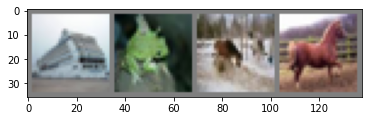

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [6]:
n_classes = 10
n_channels = 32

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(3, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
        )

        self.shortcut = nn.Conv2d(3, n_channels, kernel_size=1)
        self.poolling = nn.AvgPool2d(kernel_size=8)

        self.linear = nn.Linear(512, n_classes)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.block(x)
        x = x + shortcut
        x = nn.ReLU()(x)
        
        x = self.poolling(x)
        x = torch.flatten(x, start_dim=1)
        return self.linear(x)
        

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (poolling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps:0')
print(device)

mps:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [11]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = nn.CrossEntropyLoss()(logits, target)
        loss_log.append(loss.item())
        
        acc = torch.sum((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.sum(acc_log) / len(loader.dataset)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = nn.CrossEntropyLoss()(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = torch.sum((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 

    return np.mean(loss_log), np.sum(acc_log) / len(train_loader.dataset)

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.456367554241822, train acc: 0.481
 val loss: 1.18896805986445, val acc: 0.5782

Epoch 1
 train loss: 1.1518090542753174, train acc: 0.5980285714285715
 val loss: 1.0941569602235834, val acc: 0.622

Epoch 2
 train loss: 1.0371377784111817, train acc: 0.6394
 val loss: 1.066639392933947, val acc: 0.6280666666666667

Epoch 3
 train loss: 0.9803754016075971, train acc: 0.6587428571428572
 val loss: 1.0334040481993492, val acc: 0.6434

Epoch 4
 train loss: 0.946985999561533, train acc: 0.6708
 val loss: 1.008900463834722, val acc: 0.6492

Epoch 5
 train loss: 0.9217621738557624, train acc: 0.6802571428571429
 val loss: 0.9525623547269942, val acc: 0.6754

Epoch 6
 train loss: 0.8936642730911646, train acc: 0.6882285714285714
 val loss: 1.014182616801972, val acc: 0.6574666666666666

Epoch 7
 train loss: 0.8761659270012836, train acc: 0.6959428571428572
 val loss: 0.9492266107112803, val acc: 0.6738

Epoch 8
 train loss: 0.8590860736217534, train acc: 0.701314285714285

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8858547913041085, test acc: 0.6931


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [13]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

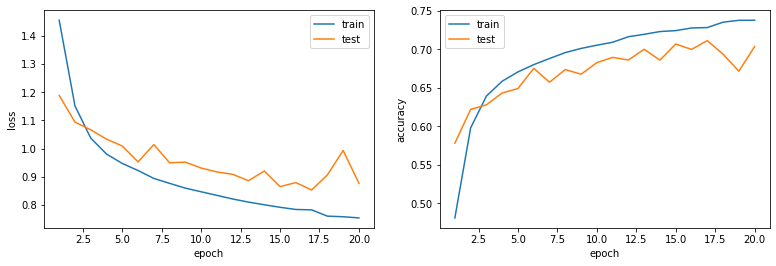

In [14]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.467185878230623, train acc: 0.47797142857142855
 val loss: 1.299528160247397, val acc: 0.5406666666666666

Epoch 1
 train loss: 1.1514279029487038, train acc: 0.5977142857142858
 val loss: 1.1171479811059668, val acc: 0.6115333333333334

Epoch 2
 train loss: 1.0470144554727474, train acc: 0.6344857142857143
 val loss: 1.234742149647246, val acc: 0.5745333333333333

Epoch 3
 train loss: 0.9902935971725575, train acc: 0.6553714285714286
 val loss: 0.9651751657749744, val acc: 0.6696

Epoch 4
 train loss: 0.9482894176974811, train acc: 0.6692857142857143
 val loss: 0.993927082609623, val acc: 0.6525333333333333

Epoch 5
 train loss: 0.9150691471544437, train acc: 0.6828285714285715
 val loss: 0.9688534898960844, val acc: 0.6650666666666667

Epoch 6
 train loss: 0.8947461999857448, train acc: 0.6866857142857142
 val loss: 0.9228874764543898, val acc: 0.686

Epoch 7
 train loss: 0.8829798511547842, train acc: 0.6935142857142857
 val loss: 0.8968249929712174, val acc: 

Посчитайте точность на тестовой выборке:

In [16]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8254122136125139, test acc: 0.7195


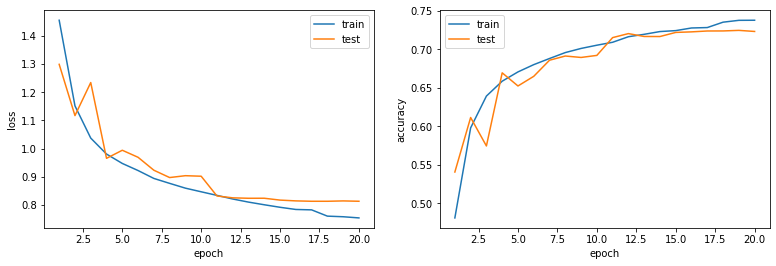

In [17]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8587587790689695, train acc: 0.34677142857142856
 val loss: 1.6385332701054025, val acc: 0.432

Epoch 1
 train loss: 1.5726039117607382, train acc: 0.4476
 val loss: 1.4885548601759242, val acc: 0.4782666666666667

Epoch 2
 train loss: 1.4449414927955084, train acc: 0.4922285714285714
 val loss: 1.4078952966852392, val acc: 0.5051333333333333

Epoch 3
 train loss: 1.3607721239382868, train acc: 0.5224571428571428
 val loss: 1.314697416285251, val acc: 0.541

Epoch 4
 train loss: 1.299684361086467, train acc: 0.5454
 val loss: 1.2577457326523802, val acc: 0.5648666666666666

Epoch 5
 train loss: 1.2457342765666886, train acc: 0.5635142857142857
 val loss: 1.215220844745636, val acc: 0.5789333333333333

Epoch 6
 train loss: 1.2047153092389569, train acc: 0.5816857142857143
 val loss: 1.202215767414012, val acc: 0.5812666666666667

Epoch 7
 train loss: 1.1603482245745127, train acc: 0.5960571428571428
 val loss: 1.1610223866523581, val acc: 0.5916666666666667

Epoch

In [19]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9371563249332889, test acc: 0.6751


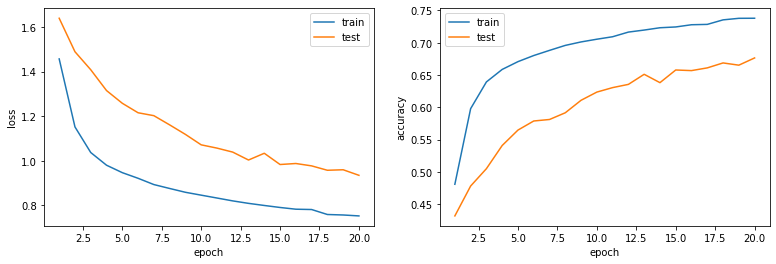

In [20]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**StepLR**: каждые `step_size` умножает изначальный `lr` на `gamma`. Таким образом можно сделать плавное затухание градиента

In [21]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.480389561361107, train acc: 0.4705714285714286
 val loss: 1.281166548170942, val acc: 0.5549333333333333

Epoch 1
 train loss: 1.1504598614066786, train acc: 0.5984285714285714
 val loss: 1.0438638205223896, val acc: 0.6367333333333334

Epoch 2
 train loss: 1.0434822476106327, train acc: 0.6357714285714285
 val loss: 1.0146230405949532, val acc: 0.647

Epoch 3
 train loss: 0.9871092266530833, train acc: 0.6554285714285715
 val loss: 1.0252554926466435, val acc: 0.6448666666666667

Epoch 4
 train loss: 0.9459372623746967, train acc: 0.6701714285714285
 val loss: 0.9795151226063992, val acc: 0.655

Epoch 5
 train loss: 0.8597243561169348, train acc: 0.6993142857142857
 val loss: 0.9107566704141333, val acc: 0.6882

Epoch 6
 train loss: 0.8425154184728479, train acc: 0.7077142857142857
 val loss: 0.8955117410801826, val acc: 0.6928

Epoch 7
 train loss: 0.830341102163796, train acc: 0.7121428571428572
 val loss: 0.8798089577796612, val acc: 0.6942666666666667

Epoch

In [22]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8280152219116308, test acc: 0.7175


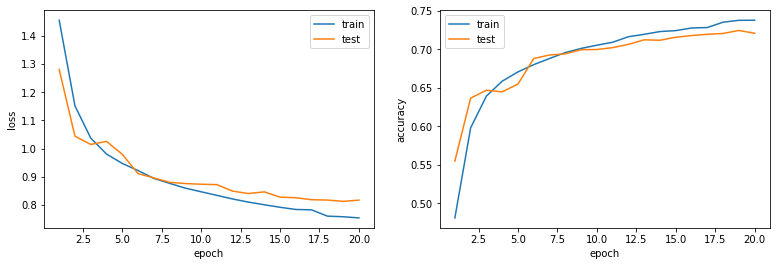

In [23]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**OneCycleLR**: сначала увеличивает изначальный `lr` до `max_lr`, после этого затухает его. Этот алгоритм был описан в статье Super-Convergence: [Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)

In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=len(train_loader), epochs=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4853981733322144, train acc: 0.46977142857142856
 val loss: 1.4077688815745901, val acc: 0.5045333333333333

Epoch 1
 train loss: 1.184420988481267, train acc: 0.5812857142857143
 val loss: 1.1247954984928699, val acc: 0.6062666666666666

Epoch 2
 train loss: 1.0617739760897495, train acc: 0.6241142857142857
 val loss: 1.0292246552223856, val acc: 0.6406

Epoch 3
 train loss: 1.0005667652029007, train acc: 0.6506
 val loss: 0.9977345174931466, val acc: 0.6537333333333334

Epoch 4
 train loss: 0.9586618096998448, train acc: 0.6671714285714285
 val loss: 0.9514699816703797, val acc: 0.6673333333333333

Epoch 5
 train loss: 0.9215421102382583, train acc: 0.6789142857142857
 val loss: 0.9637741682377268, val acc: 0.6656

Epoch 6
 train loss: 0.8963785071259661, train acc: 0.6878
 val loss: 0.9288851040474913, val acc: 0.6786

Epoch 7
 train loss: 0.8764438816572674, train acc: 0.6950571428571428
 val loss: 0.9032169486613983, val acc: 0.6859333333333333

Epoch 8
 tra

In [25]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8197468933026502, test acc: 0.7217


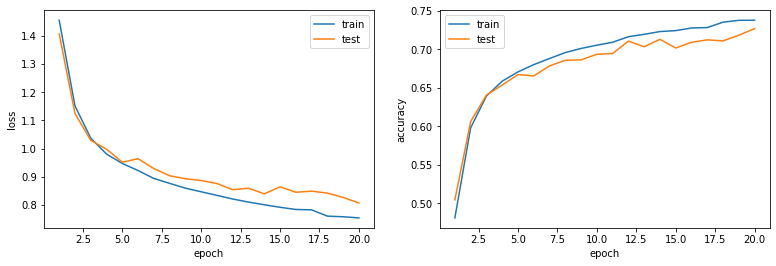

In [26]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**ConstantLR**: через `total_iters` эпох делит изначальный `lr` на `factor`. Можно изначально поставить большой `lr`, а после резко сильно его увеличть (зачем, вопрос хороший) 

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.5, total_iters=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4784469168626413, train acc: 0.47031428571428574
 val loss: 1.2525086514493253, val acc: 0.5608

Epoch 1
 train loss: 1.1650872789527642, train acc: 0.5877142857142857
 val loss: 1.098090606040143, val acc: 0.6150666666666667

Epoch 2
 train loss: 1.0463021447715202, train acc: 0.6351142857142857
 val loss: 1.0090936653157498, val acc: 0.6469333333333334

Epoch 3
 train loss: 0.9837965447680388, train acc: 0.6601714285714285
 val loss: 1.06370711808509, val acc: 0.6292666666666666

Epoch 4
 train loss: 0.9444579413429692, train acc: 0.6730571428571429
 val loss: 0.974638216799878, val acc: 0.6637333333333333

Epoch 5
 train loss: 0.9098936139556564, train acc: 0.6847142857142857
 val loss: 0.9334240390899333, val acc: 0.6754

Epoch 6
 train loss: 0.8827156470288307, train acc: 0.6952857142857143
 val loss: 0.9025205472682385, val acc: 0.6896666666666667

Epoch 7
 train loss: 0.8606280178866831, train acc: 0.7019142857142857
 val loss: 0.8986572719634848, val acc:

In [28]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9109137548003227, test acc: 0.6867


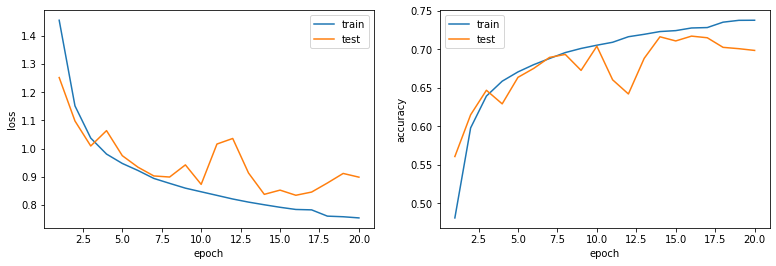

In [29]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Вывод**: особо улучшить модели не получилось. Предполагаю, что более заметный эффект будет при обучении на более большом количестве эпох. Авторы статьи про `OneCycleLR` проводили эксперименте на `ResNet` и обучали модель на `Cifar-10` в течении более `100` эпох, в итоге получили качество свыше `85%`. (как нетрудно догадаться, мне очень понравилась идея `OneCycleLR`)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

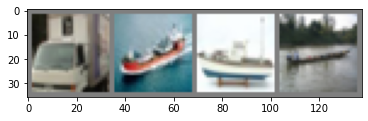

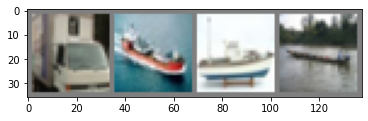

In [30]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [31]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4810771362437192, train acc: 0.47114285714285714
 val loss: 1.2472078290391475, val acc: 0.5505333333333333

Epoch 1
 train loss: 1.172279482349835, train acc: 0.5909142857142857
 val loss: 1.0811692882091442, val acc: 0.6246

Epoch 2
 train loss: 1.0553716659763832, train acc: 0.6323428571428571
 val loss: 1.0548481119439956, val acc: 0.637

Epoch 3
 train loss: 0.9993284103857316, train acc: 0.6563714285714286
 val loss: 0.9691995123599438, val acc: 0.6608

Epoch 4
 train loss: 0.9580200180493064, train acc: 0.6668857142857143
 val loss: 0.9834351980939825, val acc: 0.6554666666666666

Epoch 5
 train loss: 0.9306070661849906, train acc: 0.6785428571428571
 val loss: 0.9352275199078499, val acc: 0.6702666666666667

Epoch 6
 train loss: 0.9089861928435958, train acc: 0.6881428571428572
 val loss: 0.9670919494425997, val acc: 0.6655333333333333

Epoch 7
 train loss: 0.893833455100138, trai

Посчитайте точность на тестовой выборке:

In [32]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.7913230306403652, test acc: 0.7308


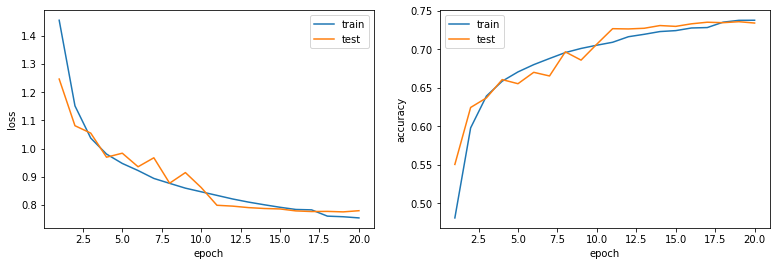

In [33]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomPerspective**: смотрим на изображение под другим углом

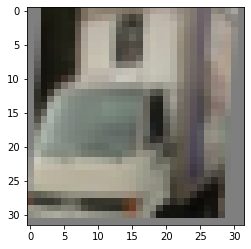

In [34]:
imshow(transforms.RandomPerspective(distortion_scale=0.2, p=1)(images[0]))

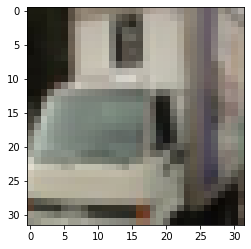

In [35]:
imshow(images[0])

In [36]:
transform = transforms.Compose(
        [transforms.RandomPerspective(distortion_scale=0.2),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.576490886686489, train acc: 0.43294285714285713
 val loss: 1.3836421976698206, val acc: 0.5002

Epoch 1
 train loss: 1.2594711813238029, train acc: 0.5536285714285715
 val loss: 1.1866844164564254, val acc: 0.5872

Epoch 2
 train loss: 1.1402647939852866, train acc: 0.5988857142857142
 val loss: 1.1058537085005578, val acc: 0.6172

Epoch 3
 train loss: 1.0722275979993985, train acc: 0.6248571428571429
 val loss: 1.0469240353462543, val acc: 0.6372

Epoch 4
 train loss: 1.0278480512786392, train acc: 0.6409142857142858
 val loss: 1.184491738359979, val acc: 0.5986

Epoch 5
 train loss: 1.0018535626871712, train acc: 0.6510285714285714
 val loss: 1.0497207915529292, val acc: 0.6374666666666666

Epoch 6
 train loss: 0.9798903740956099, train acc: 0.6582857142857143
 val loss: 0.9768515363652656, val acc: 0.6599333333333334

Epoch 7
 train loss: 0.9645899806641574, train acc: 0.66397142857142

In [37]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8340056760675588, test acc: 0.7144


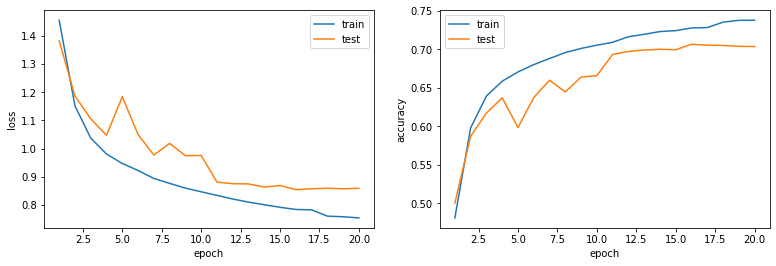

In [38]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**ColorJitter**: меняем яркость, контрастность, насыщенность изображения

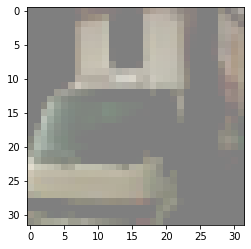

In [57]:
imshow(transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01)(images[0]))

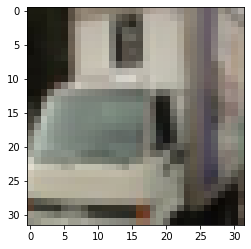

In [58]:
imshow(images[0])

In [45]:
transform = transforms.Compose(
        [transforms.RandomApply([
                transforms.ColorJitter(brightness=0.1),
                transforms.ColorJitter(contrast=0.01),
                transforms.ColorJitter(saturation=0.01),
         ]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.484799879124657, train acc: 0.47322857142857144
 val loss: 1.2884860918876972, val acc: 0.5422666666666667

Epoch 1
 train loss: 1.1703872877893327, train acc: 0.5901142857142857
 val loss: 1.0896263500477406, val acc: 0.6206666666666667

Epoch 2
 train loss: 1.0567278328063936, train acc: 0.6300285714285714
 val loss: 1.0789965043676661, val acc: 0.6310666666666667

Epoch 3
 train loss: 0.991708255119254, train acc: 0.6529714285714285
 val loss: 1.012581090216941, val acc: 0.6514

Epoch 4
 train loss: 0.952660274788928, train acc: 0.6694857142857142
 val loss: 1.0091900310617812, val acc: 0.648

Epoch 5
 train loss: 0.922119257001162, train acc: 0.6797428571428571
 val loss: 0.9897036346983402, val acc: 0.6583333333333333

Epoch 6
 train loss: 0.8972024567820255, train acc: 0.6878
 val loss: 0.9525670533484601, val acc: 0.6693333333333333

Epoch 7
 train loss: 0.884927527941559, train ac

In [46]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.829098138839576, test acc: 0.7168


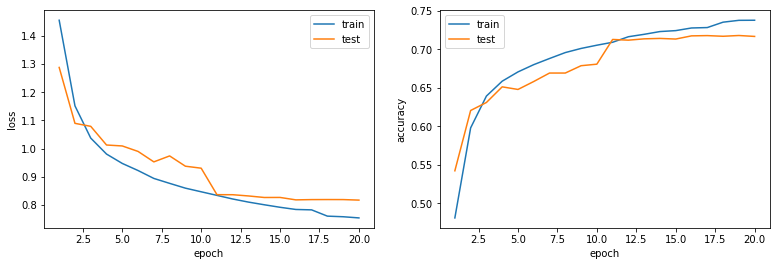

In [47]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**RandomHorizontalFlip && RandomPerspective && ColorJitter**:

In [59]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(p=0.3),
         transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
         transforms.RandomApply([
                transforms.ColorJitter(brightness=0.01),
                transforms.ColorJitter(contrast=0.01),
                transforms.ColorJitter(saturation=0.01),
         ], p=0.3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5515788924323575, train acc: 0.4439142857142857
 val loss: 1.3888536361937827, val acc: 0.4968666666666667

Epoch 1
 train loss: 1.2446428397891727, train acc: 0.5580571428571428
 val loss: 1.1475509681600204, val acc: 0.5994666666666667

Epoch 2
 train loss: 1.120987003638496, train acc: 0.6068571428571429
 val loss: 1.051856928429705, val acc: 0.6347333333333334

Epoch 3
 train loss: 1.064114010857054, train acc: 0.6274857142857143
 val loss: 1.045687874073678, val acc: 0.637

Epoch 4
 train loss: 1.0230034049293895, train acc: 0.6429142857142857
 val loss: 1.0462838533076835, val acc: 0.6351333333333333

Epoch 5
 train loss: 0.9946445771501531, train acc: 0.6548
 val loss: 0.9992247662645706, val acc: 0.6503333333333333

Epoch 6
 train loss: 0.9730327122826027, train acc: 0.6623714285714286
 val loss: 0.9688598150902606, val acc: 0.6598666666666667

Epoch 7
 train loss: 0.9564097144486

In [60]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8120619335751624, test acc: 0.7226


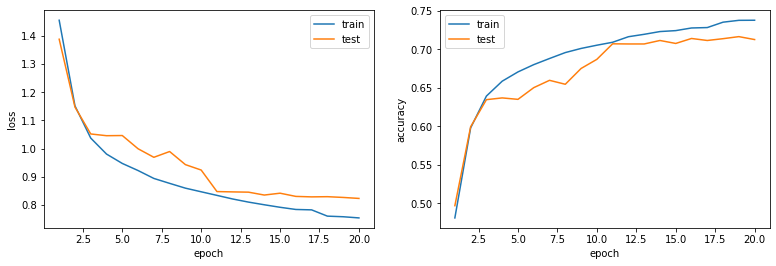

In [61]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Вывод**: качество модели не выросло. Если сравнивать с обучением без аугментирования данных, то качество улучшилось, но если сравнивать между собой `RandomHorizontalFlip`, `ColorJitter` и `RandomPerspective`, то лучше всего себя показывает `RandomHorizontalFlip`. Скорее всего `ColorJitter` и `RandomPerspective` лучше бы себя показали на менее шакальных изображениях, не на фото 32 $\times$ 32.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [12]:
import wandb
wandb.login()

wandb: Currently logged in as: tutugarin. Use `wandb login --relogin` to force relogin


True

In [13]:
config = {
  "dataset": "CIFAR10",
  "machine": "MacBook Pro m1",
  "model": "BaseBlockNet",
  "learning_rate": 0.1,
  "batch_size": 64,
}

wandb.init(
    project="dl-shw-02-cnn",
    config=config
)


Добавим в нашу функцию обучения логирование в `wandb`:

In [14]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        metrics = {
            "train loss": train_loss, 
            "val loss": val_loss,
            "train acc": train_acc, 
            "val acc": val_acc,
        }

        wandb.log(metrics)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [15]:
net = BasicBlockNet().to(device)
# wandb.watch(net, log_freq=100)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
wandb.finish()

Epoch 0
 train loss: 1.495171721936144, train acc: 0.46708571428571427
 val loss: 1.2765259707227665, val acc: 0.5542

Epoch 1
 train loss: 1.1739042256388412, train acc: 0.5897142857142857
 val loss: 1.1608378851667362, val acc: 0.6012666666666666

Epoch 2
 train loss: 1.0599552273096506, train acc: 0.6324
 val loss: 1.0309000043158836, val acc: 0.6419333333333334

Epoch 3
 train loss: 1.009277177794106, train acc: 0.6509714285714285
 val loss: 0.9979753025034641, val acc: 0.6561333333333333

Epoch 4
 train loss: 0.9707203813619109, train acc: 0.666
 val loss: 0.9536732333771726, val acc: 0.6721333333333334

Epoch 5
 train loss: 0.9403954586337646, train acc: 0.6737714285714286
 val loss: 0.9565753782049139, val acc: 0.6688666666666667

Epoch 6
 train loss: 0.9131177164736788, train acc: 0.6812285714285714
 val loss: 0.9302225353869986, val acc: 0.6762

Epoch 7
 train loss: 0.8958911183111411, train acc: 0.6856857142857142
 val loss: 0.9449794964587435, val acc: 0.6754666666666667

Ep

train acc,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val acc,▁▃▅▆▆▆▆▆▇▆▇▅▆█▇▇▇▇▇█
val loss,█▆▄▃▃▃▂▃▂▃▂▄▃▁▂▂▃▂▂▁
train acc,0.73626
train loss,0.7634
val acc,0.7102
val loss,0.85303


Ссылка на графики с точностью: 
https://wandb.ai/tutugarin/dl-shw-02-cnn/reports/train-acc-val-acc-22-11-05-12-17-51---VmlldzoyOTE1NTky

Ссылка на графики с ошибкой: 
https://wandb.ai/tutugarin/dl-shw-02-cnn/reports/train-loss-val-loss-22-11-05-12-18-09---VmlldzoyOTE1NTk3